# Generating Synthetic MMM Data

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
from pymc import do
from pymc_extras.prior import Prior

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.multidimensional import MMM

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Generating Covariates Data

In [3]:
n_dates = 200

date_range = pd.date_range(start="2020-01-01", freq="W-MON", periods=n_dates)

coords = {"channel": ["x1", "x2", "x3"], "date": date_range}

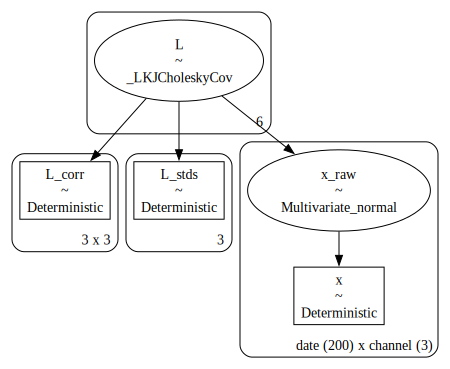

In [4]:
with pm.Model(coords=coords) as covariates_model:
    L, _, _ = pm.LKJCholeskyCov(
        "L", n=len(coords["channel"]), eta=2, sd_dist=pm.Exponential.dist(lam=1)
    )

    x_raw = pm.MvNormal("x_raw", mu=0, chol=L, dims=("date", "channel"))

    x = pm.Deterministic("x", pt.softplus(x_raw), dims=("date", "channel"))

pm.model_to_graphviz(covariates_model)

In [5]:
x_data = pm.draw(covariates_model.x, draws=1, random_seed=rng)

mmm_df = pd.DataFrame(x_data, columns=coords["channel"]).assign(
    date=date_range, y_dummy=np.ones(n_dates)
)

col = mmm_df.pop("date")
mmm_df.insert(0, "date", col)

mmm_df.head()

,date,x1,x2,x3,y_dummy
0,2020-01-06,1.141244,0.460174,0.753593,1.0
1,2020-01-13,0.406537,0.325582,0.727844,1.0
2,2020-01-20,0.118057,0.491115,0.935238,1.0
3,2020-01-27,0.592934,0.471189,0.984930,1.0
4,2020-02-03,0.145039,1.321992,0.819730,1.0


## Specify Model Configuration

In [6]:
intercept_true = pm.draw(pm.Normal.dist(), draws=1, random_seed=rng)
adstock_alpha_true = pm.draw(
    pm.Beta.dist(alpha=1, beta=3), draws=len(coords["channel"]), random_seed=rng
)
saturation_beta_true = pm.draw(
    pm.HalfNormal.dist(sigma=2), draws=len(coords["channel"]), random_seed=rng
)
saturation_lam_true = pm.draw(
    pm.Gamma.dist(alpha=3, beta=1), draws=len(coords["channel"]), random_seed=rng
)

fourier_mode_true = pm.draw(pm.Normal.dist(), random_seed=rng)

sigma_likelihood_true = pm.draw(pm.HalfNormal.dist(sigma=3), draws=1, random_seed=rng)


# model_config_generator = {
#     "intercept": Prior("DiracDelta", c=intercept_true),
#     "adstock_alpha": Prior("DiracDelta", c=adstock_alpha_true, dims="channel"),
#     "saturation_beta": Prior("DiracDelta", c=saturation_beta_true, dims="channel"),
#     "saturation_lam": Prior("DiracDelta", c=saturation_lam_true, dims="channel"),
#     "gamma_fourier": Prior("Normal", mu=0, sigma=0.2, dims="fourier_mode"),
#     "likelihood": Prior("TruncatedNormal", sigma=sigma_likelihood_true, lower=0),
# }

model_config_generator = {
    "intercept": Prior("Normal", mu=0, sigma=1),
    "adstock_alpha": Prior("Beta", alpha=1, beta=3, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=3, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=3, beta=1, dims="channel"),
    "gamma_control": Prior("Normal", mu=0, sigma=1, dims="control"),
    "gamma_fourier": Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=3)),
}

mmm_generator = MMM(
    date_column="date",
    target_column="y_dummy",
    channel_columns=coords["channel"],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
    yearly_seasonality=2,
    model_config=model_config_generator,
)

## Generate Target Variable

In [7]:
X = mmm_df.drop(columns=["y_dummy"])
y_dummy = mmm_df["y_dummy"]

mmm_generator.build_model(X, y_dummy)

In [8]:
mmm_generator.model = do(
    mmm_generator.model,
    {
        "intercept_contribution": intercept_true,
        "adstock_alpha": adstock_alpha_true,
        "saturation_beta": saturation_beta_true,
        "saturation_lam": saturation_lam_true,
        # "gamma_fourier": fourier_mode_true,
    },
)

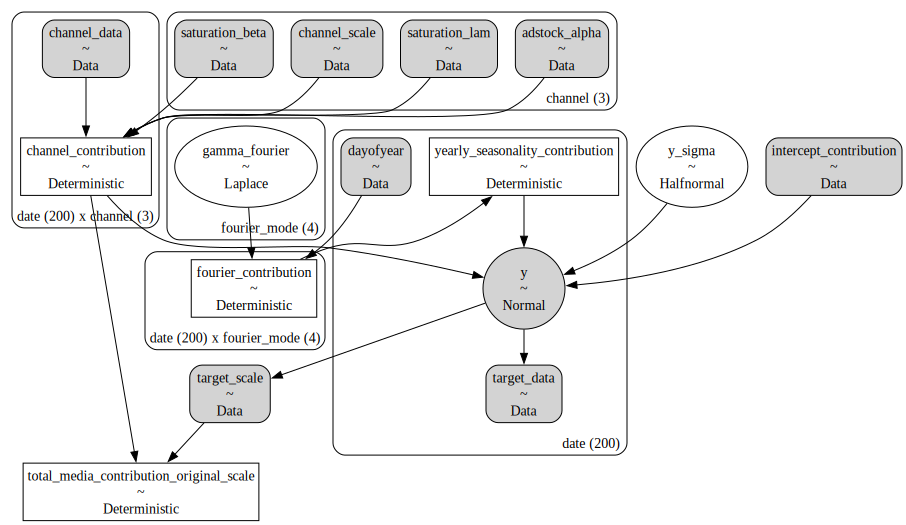

In [9]:
pm.model_to_graphviz(mmm_generator.model)

In [10]:
mmm_generator.model_config

{'intercept': Prior("Normal", mu=0, sigma=1),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=3), dims="date"),
 'gamma_control': Prior("Normal", mu=0, sigma=1, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=3, dims="channel")}

In [11]:
y_obs = pm.draw(mmm_generator.model.y, draws=1, random_seed=rng)

mmm_df["y_obs"] = y_obs

mmm_df.head()

,date,x1,x2,x3,y_dummy,y_obs
0,2020-01-06,1.141244,0.460174,0.753593,1.0,2.211971
1,2020-01-13,0.406537,0.325582,0.727844,1.0,0.831961
2,2020-01-20,0.118057,0.491115,0.935238,1.0,0.189433
3,2020-01-27,0.592934,0.471189,0.984930,1.0,-0.844775
4,2020-02-03,0.145039,1.321992,0.819730,1.0,1.057968


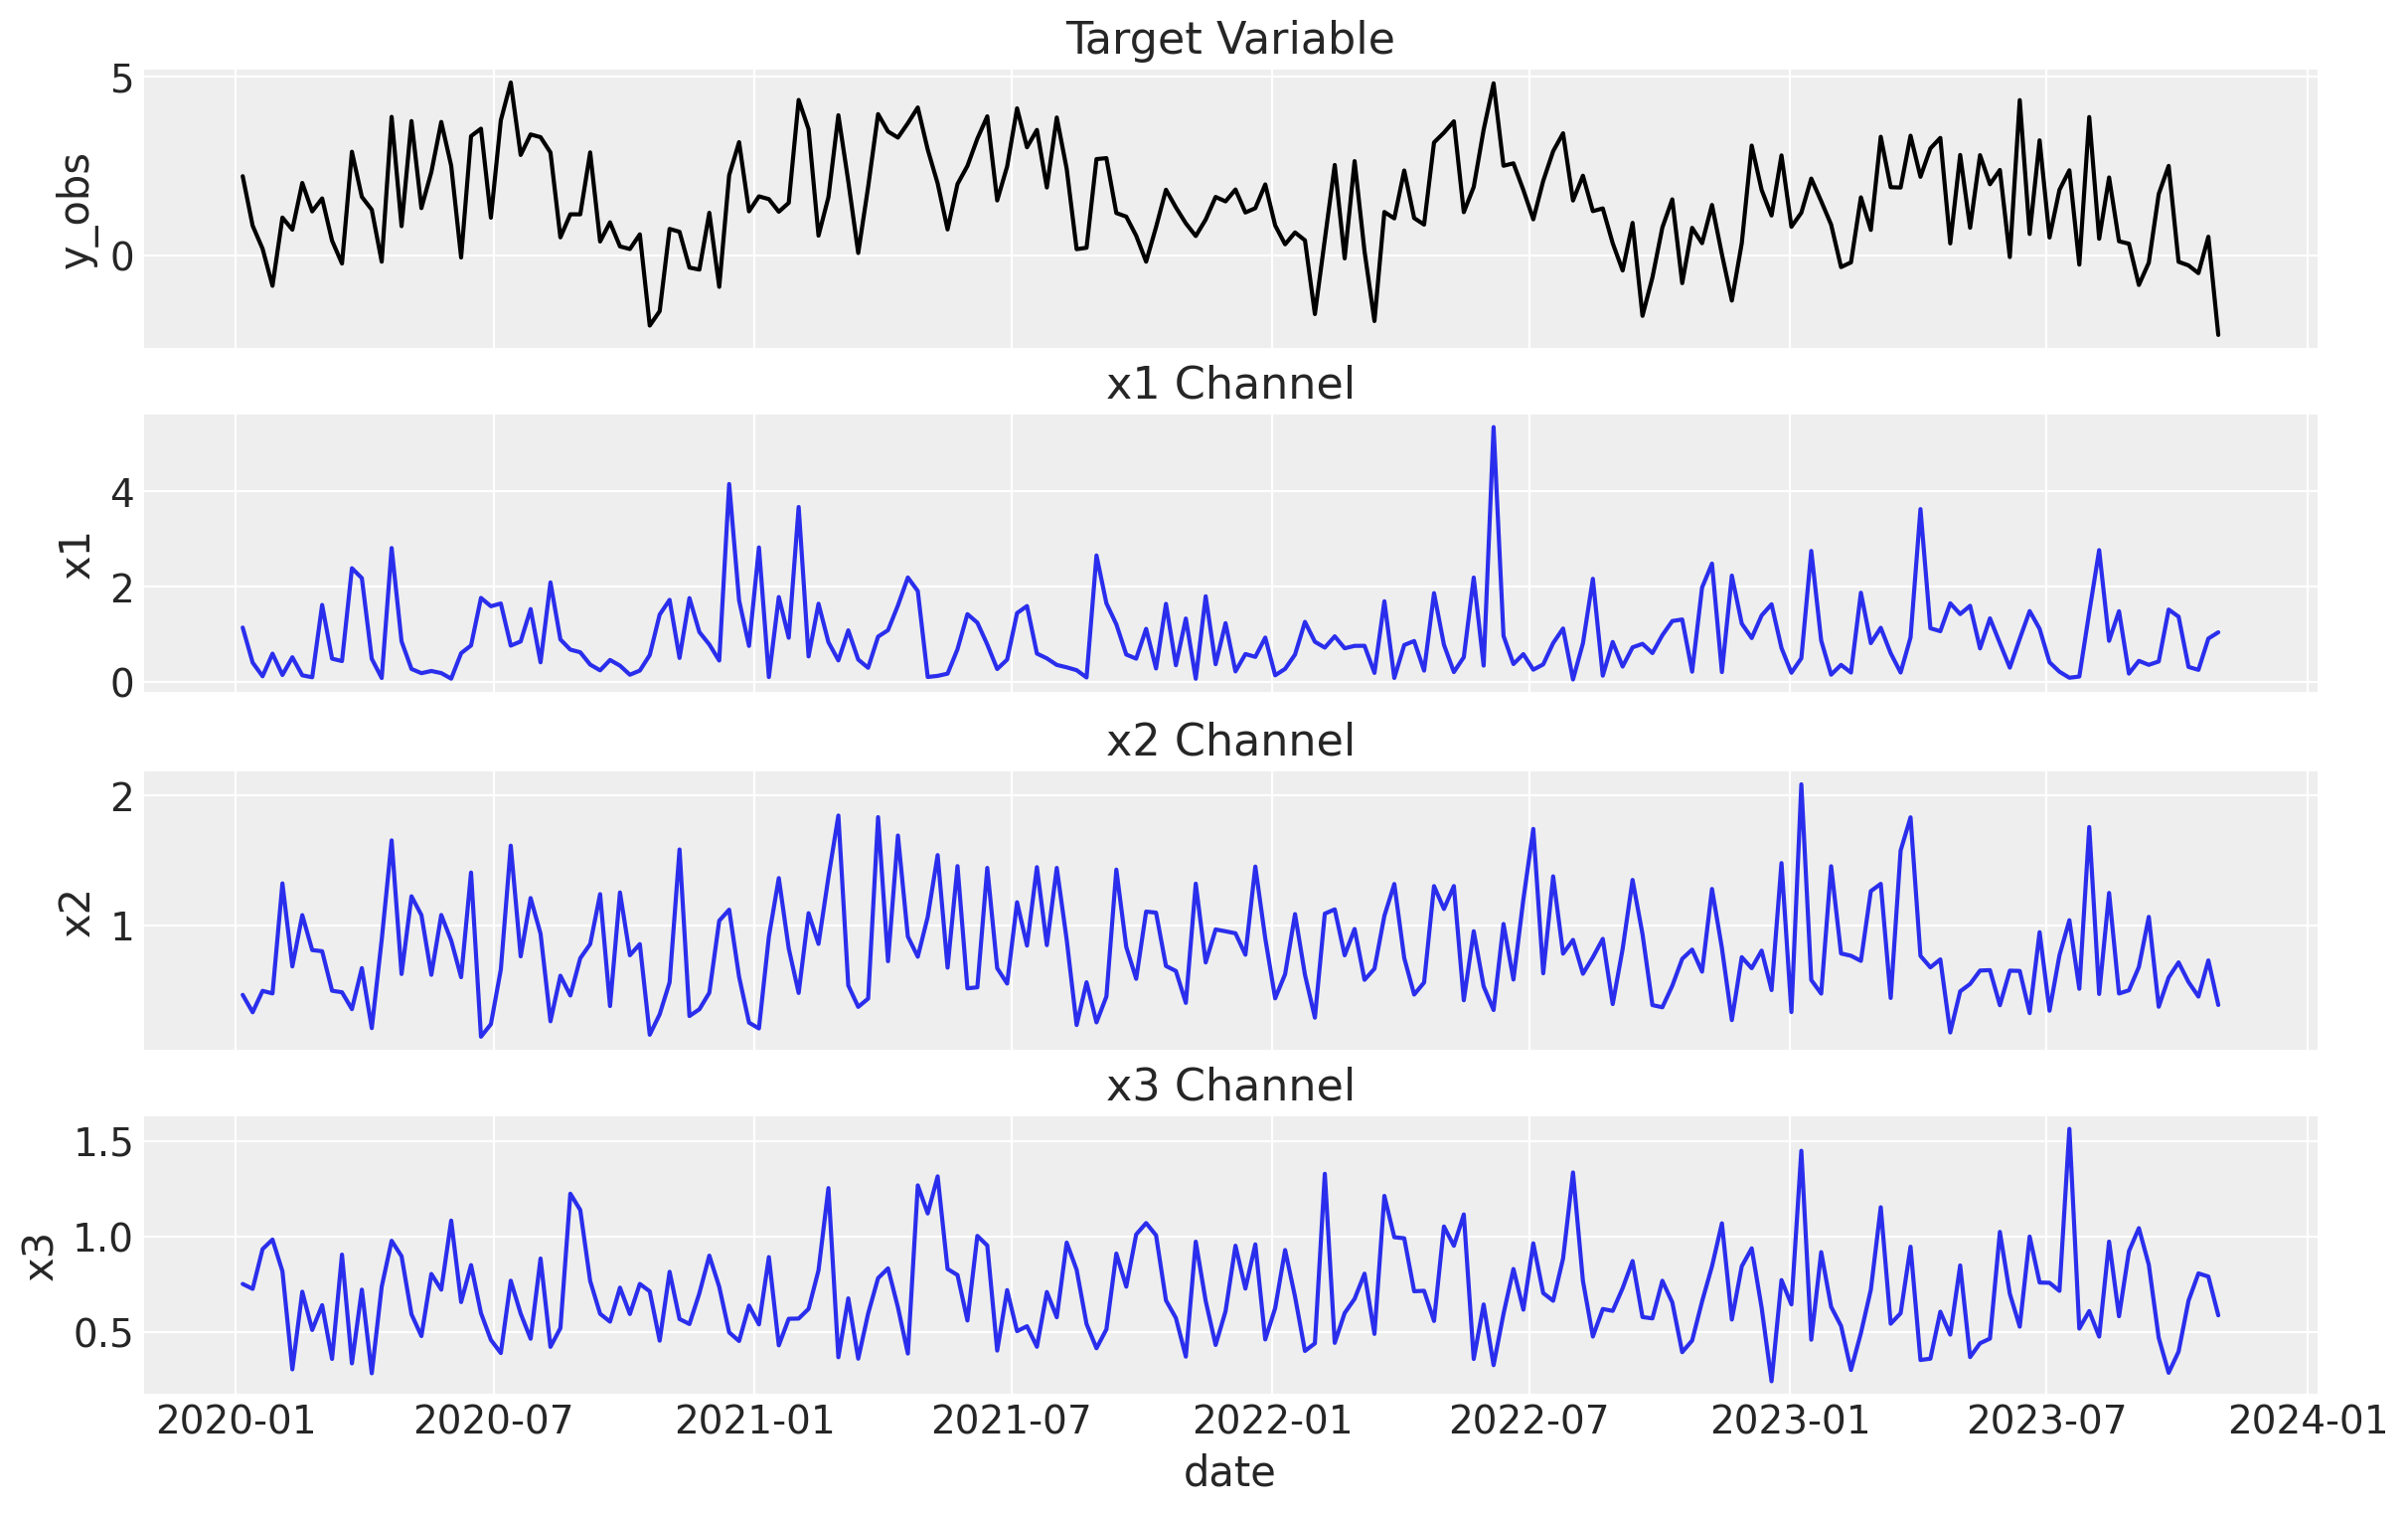

In [12]:
fig, ax = plt.subplots(
    nrows=len(coords["channel"]) + 1,
    figsize=(12, len(coords["channel"]) * 2.5),
    sharex=True,
)

sns.lineplot(x="date", y="y_obs", data=mmm_df, color="black", ax=ax[0])
ax[0].set_title("Target Variable")

for i, channel in enumerate(coords["channel"]):
    sns.lineplot(x="date", y=channel, data=mmm_df, color="C0", ax=ax[i + 1])
    ax[i + 1].set_title(f"{channel} Channel")

## Parameter Recovery

In [13]:
model_config = {
    "intercept": Prior("Normal", mu=5, sigma=1),
    "adstock_alpha": Prior("Beta", alpha=1, beta=3, dims="channel"),
    "saturation_beta": Prior("HalfNormal", sigma=3, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=3, beta=1, dims="channel"),
    "gamma_control": Prior("Normal", mu=0, sigma=1, dims="control"),
    "gamma_fourier": Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
    "likelihood": Prior("Normal", sigma=Prior("HalfNormal", sigma=3)),
}

mmm = MMM(
    date_column="date",
    target_column="y_obs",
    channel_columns=coords["channel"],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
    yearly_seasonality=2,
    model_config=model_config,
    sampler_config={"nuts_sampler": "nutpie"},
)

_ = mmm.fit(
    X,
    mmm_df["y_obs"],
    chains=4,
    tune=1_500,
    draws=1_000,
    target_accept=0.95,
    random_seed=rng,
)

_ = mmm.sample_posterior_predictive(X=X, random_seed=rng)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,2500,0,0.12,63
,2500,0,0.15,31
,2500,0,0.13,31
,2500,0,0.13,31


Output()

Sampling: [y]


Output()

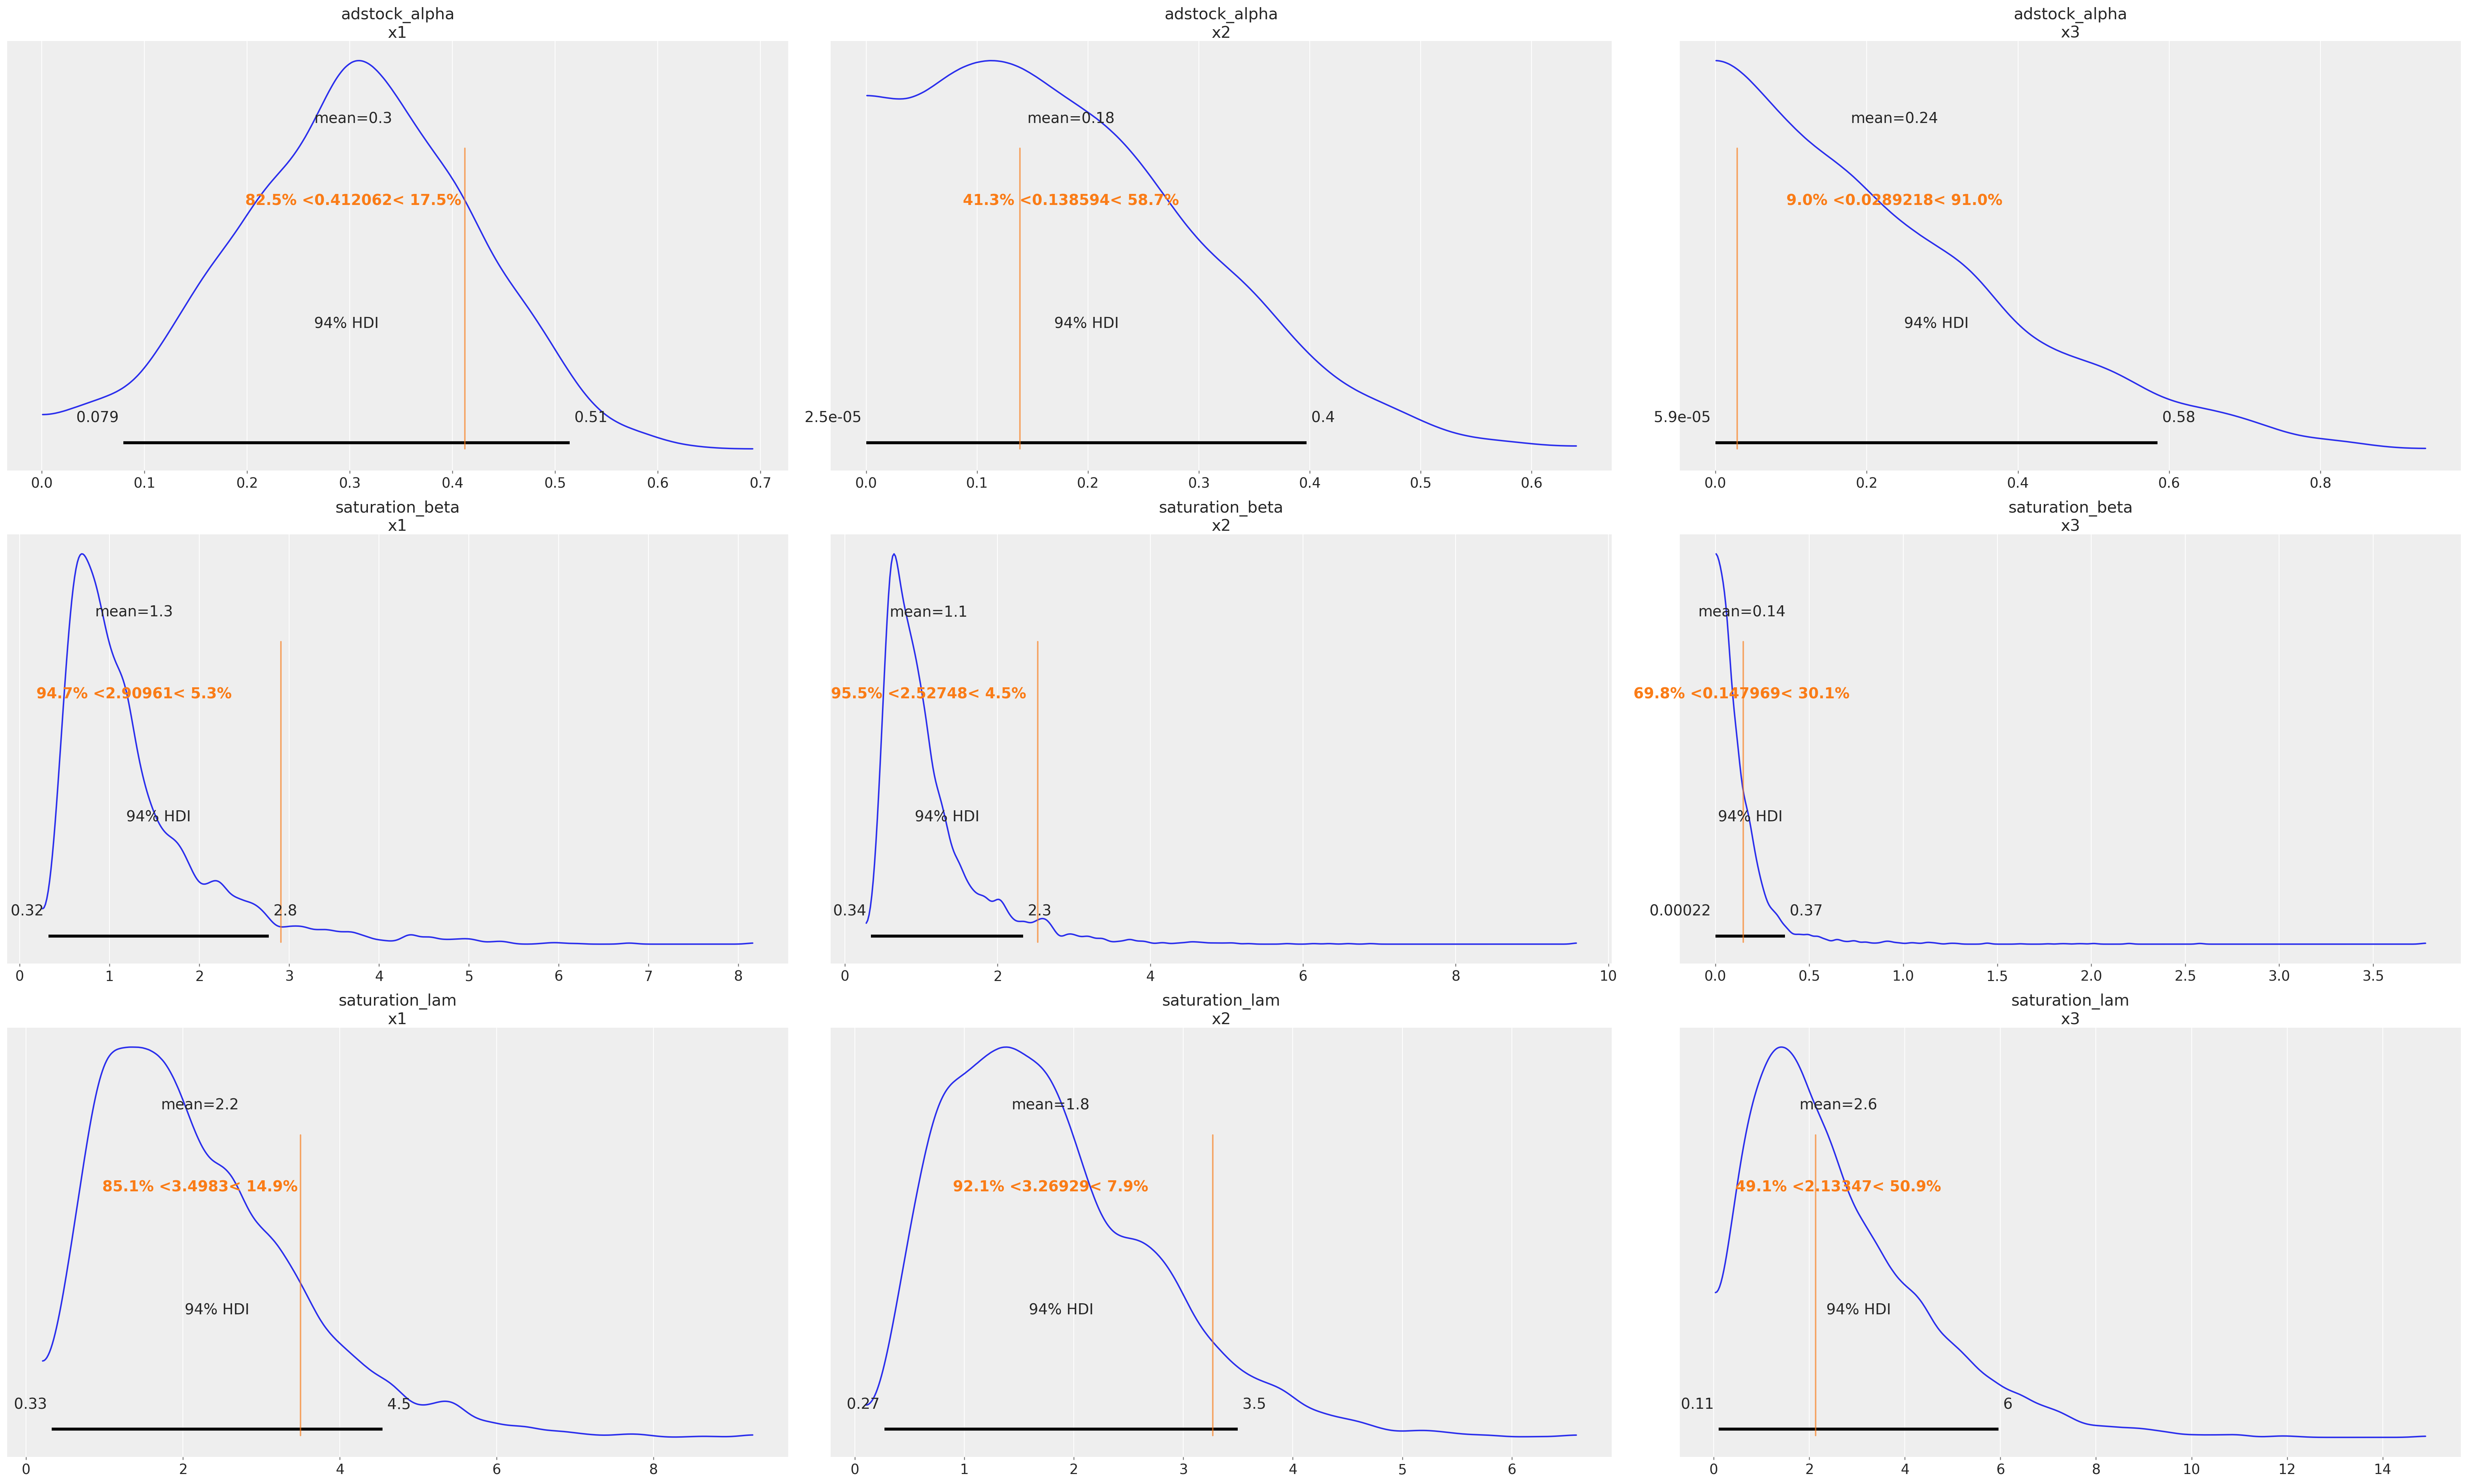

In [14]:
az.plot_posterior(
    mmm.idata,
    var_names=[
        "adstock_alpha",
        "saturation_beta",
        "saturation_lam",
    ],
    ref_val={
        "adstock_alpha": [
            {"channel": "x1", "ref_val": adstock_alpha_true[0]},
            {"channel": "x2", "ref_val": adstock_alpha_true[1]},
            {"channel": "x3", "ref_val": adstock_alpha_true[2]},
        ],
        "saturation_beta": [
            {"channel": "x1", "ref_val": saturation_beta_true[0]},
            {"channel": "x2", "ref_val": saturation_beta_true[1]},
            {"channel": "x3", "ref_val": saturation_beta_true[2]},
        ],
        "saturation_lam": [
            {"channel": "x1", "ref_val": saturation_lam_true[0]},
            {"channel": "x2", "ref_val": saturation_lam_true[1]},
            {"channel": "x3", "ref_val": saturation_lam_true[2]},
        ],
    },
);

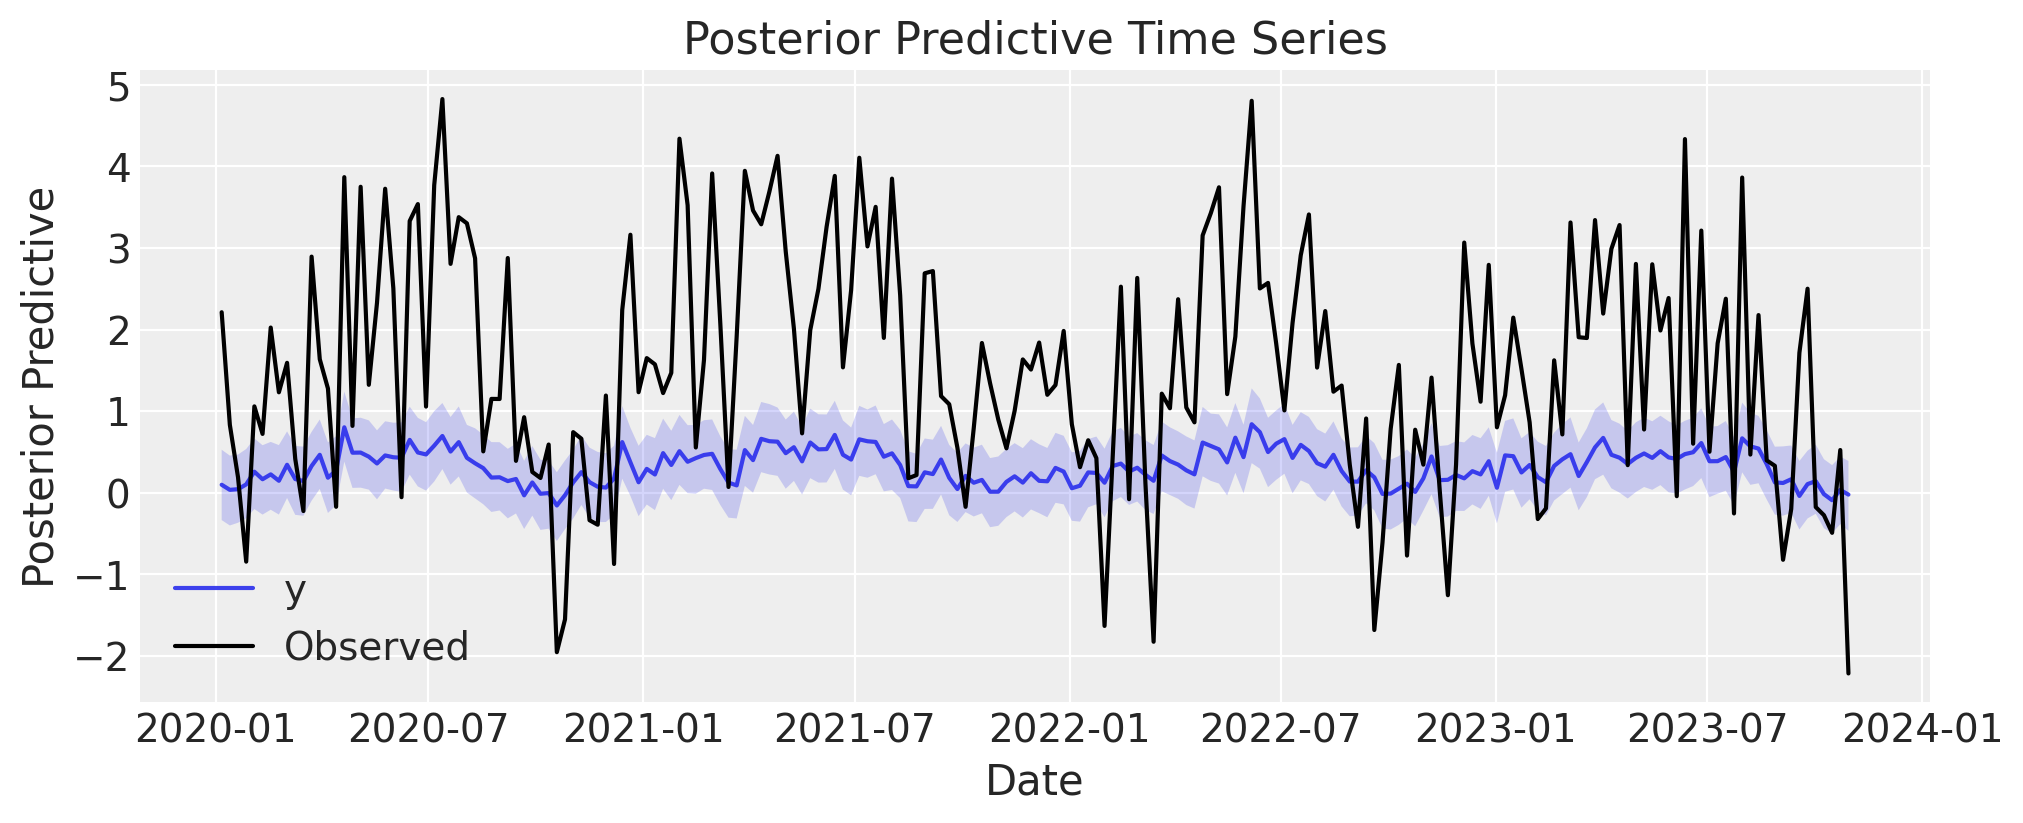

In [15]:
fig, axes = mmm.plot.posterior_predictive(var=["y"], hdi_prob=0.94)
sns.lineplot(
    data=mmm_df, x="date", y="y_obs", color="black", label="Observed", ax=axes[0][0]
);